In [3]:
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from utils.data.datasets import ModelParamsDataset
import wandb
from utils.config import config as cfg

from utils.model.models import MLP
from utils.data.helpers import list_to_model, get_moons_dataset
from utils.visualization.visualize import plot_decision_boundary

import pandas as pd

In [4]:
class ModelParamsDataset2(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.iloc[:10000]
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx]/self.angle_change, dtype=torch.int64)
        angle = torch.nn.functional.one_hot(angle, num_classes=int(360/self.angle_change)).float()

        return weights, angle

### Variational Autoencoder to generate weights

In [2]:
def reparameterize(mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(151, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU()
        )
        self.fc_mean = torch.nn.Linear(50, 10)
        self.fc_var = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        var = self.fc_var(x)

        return mean, var
    

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 151),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mean, var  = self.encoder(x)
        x = reparameterize(mean, var)
        x = self.decoder(x)
        return x, mean, var
        


In [4]:
def total_loss_function(x, x_hat, mean, var):
    reconstruction_loss = nn.MSELoss()(x_hat, x)
    kl_divergence = -0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())
    return reconstruction_loss + kl_divergence

In [91]:
dataset = ModelParamsDataset("../data/eight_angles.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Model 
encoder = Encoder()
decoder = Decoder()
autoencoder = VariationalAutoencoder(encoder, decoder)
autoencoder.to(device)

# Hyperparameters
epochs = 100
learning_rate = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for X, y in dataloader:
        X = X.to(device)
        pred, mean, var = autoencoder(X)
        loss = total_loss_function(X, pred, mean, var)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}: Loss: {total_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss: 601.4851469993591
Epoch 2: Loss: 456.4597460627556
Epoch 3: Loss: 455.0621882677078
Epoch 4: Loss: 454.91756695508957
Epoch 5: Loss: 454.8931922316551
Epoch 6: Loss: 454.8829765319824
Epoch 7: Loss: 454.8800668120384
Epoch 8: Loss: 454.87445533275604
Epoch 9: Loss: 454.87106889486313
Epoch 10: Loss: 454.8775908946991
Epoch 11: Loss: 454.87186872959137
Epoch 12: Loss: 454.86678367853165
Epoch 13: Loss: 454.86648881435394
Epoch 14: Loss: 454.8668220639229
Epoch 15: Loss: 454.858863055706
Epoch 16: Loss: 454.86590456962585
Epoch 17: Loss: 454.86156874895096
Epoch 18: Loss: 454.854065656662
Epoch 19: Loss: 454.8579480648041
Epoch 20: Loss: 454.8530634045601
Epoch 21: Loss: 454.85690796375275
Epoch 22: Loss: 454.85217702388763
Epoch 23: Loss: 454.8535403609276
Epoch 24: Loss: 454.8458946943283
Epoch 25: Loss: 454.8507515192032
Epoch 26: Loss: 454.845376431942
Epoch 27: Loss: 454.8445802330971
Epoch 28: Loss: 454.8407766222954
Epoch 29: Loss: 454.8404123187065
Epoch 30: Loss: 

### Autoencoder

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(151, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 32),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, 151),
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
import pandas as pd

class ModelParamsDataset2(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.iloc[:10000]
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"])
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].astype('float32').values)
        angle = torch.tensor(self.angles.iloc[idx]/self.angle_change, dtype=torch.int64)
        angle = torch.nn.functional.one_hot(angle, num_classes=int(360/self.angle_change)).float()

        return weights, angle

In [4]:
config = {
    "model":{
        "name": "Autoencoder with batchnorm",
        "layers": [151, 64, 32, 10]
    },
    "hyperparameters":{
        "epochs": 500,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]


encoder = Encoder()
decoder = Decoder()
model = Autoencoder(encoder, decoder)
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

wandb_config = cfg.load_env()
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder")

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

# wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: Loss: 0.6856549978256226
Epoch 2: Loss: 0.6568479537963867
Epoch 3: Loss: 0.6603942513465881
Epoch 4: Loss: 0.6277378797531128
Epoch 5: Loss: 0.6524161100387573
Epoch 6: Loss: 0.6357901692390442
Epoch 7: Loss: 0.620259165763855
Epoch 8: Loss: 0.6248916983604431
Epoch 9: Loss: 0.6157881617546082
Epoch 10: Loss: 0.6275361180305481
Epoch 11: Loss: 0.6184521317481995
Epoch 12: Loss: 0.6389187574386597
Epoch 13: Loss: 0.6336418390274048
Epoch 14: Loss: 0.6199688911437988
Epoch 15: Loss: 0.6175229549407959
Epoch 16: Loss: 0.6256035566329956
Epoch 17: Loss: 0.6075537800788879
Epoch 18: Loss: 0.6203482151031494
Epoch 19: Loss: 0.6300367712974548
Epoch 20: Loss: 0.6166913509368896
Epoch 21: Loss: 0.6298642158508301
Epoch 22: Loss: 0.6314112544059753
Epoch 23: Loss: 0.6156005859375
Epoch 24: Loss: 0.6150078773498535
Epoch 25: Loss: 0.6261707544326782
Epoch 26: Loss: 0.6217164397239685
Epoch 27: Loss: 0.6181477308273315
Epoch 28: Loss: 0.6285056471824646
Epoch 29: Loss: 0.623243927955627

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

latent = []
angles = []

model.eval()
for i in tqdm(range(len(dataset))):
    X, y = dataset[i]
    X = X.unsqueeze(0).to(device)
    pred = model.encoder(X)
    latent.append(pred.cpu().detach().numpy())
    angles.append(y.cpu().detach().numpy())

latent = np.array(latent).reshape(-1, 10)
angles = np.array(angles).reshape(-1, 8)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent)
plt.scatter(X_pca[:,0], X_pca[:,1], c=angles.dot([0, 45, 90, 135, 180, 225, 270, 315]))
plt.colorbar()
plt.show()

  0%|          | 0/80000 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'dot'

### Transformers

In [127]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(TransformerAutoencoder, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=33, nhead=8, batch_first=True)
        self.decoder = nn.TransformerDecoderLayer(d_model=33, nhead=8, batch_first=True)
    
    def forward(self, x):
        for i in range(x.shape[1]):
            x = self.encoder(x)
        for i in range(x.shape[1]):
            x = self.decoder(x)
        return x

In [129]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "model":{
        "name": "TransformerAutoencoder",
        "layers": [151, 151]
    },
    "hyperparameters":{
        "epochs": 2500,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

encoder_layer = nn.TransformerEncoderLayer(151, 1, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(151, 1, batch_first=True)
model = TransformerAutoencoder(encoder_layer, decoder_layer)
model.to(device)

dataset = ModelParamsDataset2("../data/eight_angles.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1: Loss: 0.7340924143791199
Epoch 2: Loss: 0.7367677092552185
Epoch 3: Loss: 0.7204499840736389
Epoch 4: Loss: 0.7204369306564331
Epoch 5: Loss: 0.7304290533065796
Epoch 6: Loss: 0.7147870063781738
Epoch 7: Loss: 0.7260206937789917
Epoch 8: Loss: 0.7199426293373108
Epoch 9: Loss: 0.7369989156723022
Epoch 10: Loss: 0.7386513948440552
Epoch 11: Loss: 0.7171112298965454
Epoch 12: Loss: 0.7199451327323914
Epoch 13: Loss: 0.7263938784599304
Epoch 14: Loss: 0.7269039750099182
Epoch 15: Loss: 0.7260600924491882
Epoch 16: Loss: 0.7270817756652832
Epoch 17: Loss: 0.736635148525238
Epoch 18: Loss: 0.7246676087379456
Epoch 19: Loss: 0.7203274965286255
Epoch 20: Loss: 0.7286211252212524
Epoch 21: Loss: 0.7223758101463318
Epoch 22: Loss: 0.7295088768005371
Epoch 23: Loss: 0.7313674688339233
Epoch 24: Loss: 0.7083562612533569
Epoch 25: Loss: 0.7221148014068604
Epoch 26: Loss: 0.7202922701835632
Epoch 27: Loss: 0.7185958623886108
Epoch 28: Loss: 0.7411184310913086
Epoch 29: Loss: 0.731828927993

KeyboardInterrupt: 

In [138]:
weights = dataset[0][0].unsqueeze(0).to(device)
out = encoder_layer(weights)
print(out.shape)
print(out.max())
print(out.min())

torch.Size([1, 151])
tensor(0.4796, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5255, device='cuda:0', grad_fn=<MinBackward1>)


### Autoencoder small

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        self.w1 = nn.Parameter(torch.randn(16, 33))
        self.w2 = nn.Parameter(torch.randn(8, 16))
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8)
        )

        # torch.nn.init.eye_(self.encoder[0].weight)
        # torch.nn.init.eye_(self.encoder[2].weight)

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 33)
        )

        # torch.nn.init.eye_(self.decoder[0].weight)
        # torch.nn.init.eye_(self.decoder[2].weight)

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # self.encoder = Encoder()
        # self.decoder = Decoder()

        self.w1 = nn.Parameter(torch.randn(16, 33))
        self.w2 = nn.Parameter(torch.randn(8, 16))
    
    def forward(self, x):
        x = nn.functional.linear(x, self.w1)
        x = nn.ReLU()(x)
        x = nn.functional.linear(x, self.w2)

        x = nn.functional.linear(x, self.w2.T)
        x = nn.ReLU()(x)
        x = nn.functional.linear(x, self.w1.T)
        
        return x

In [17]:
config = {
    "model":{
        "name": "Autoencoder small with batchnorm",
        "layers": [33, 16, 8]
    },
    "hyperparameters":{
        "epochs": 30,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

torch.manual_seed(0)
model = Autoencoder()
model.to(device)
loss_function = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Loss: 89.16635131835938
Epoch 2: Loss: 27.932722091674805
Epoch 3: Loss: 11.401237487792969
Epoch 4: Loss: 4.473718166351318
Epoch 5: Loss: 2.2543535232543945
Epoch 6: Loss: 1.9349336624145508
Epoch 7: Loss: 1.7949427366256714
Epoch 8: Loss: 1.882680892944336
Epoch 9: Loss: 1.754772663116455
Epoch 10: Loss: 1.8172506093978882
Epoch 11: Loss: 1.7933764457702637
Epoch 12: Loss: 1.6639074087142944
Epoch 13: Loss: 1.6669423580169678
Epoch 14: Loss: 1.6342352628707886
Epoch 15: Loss: 1.6436243057250977
Epoch 16: Loss: 1.6364469528198242
Epoch 17: Loss: 1.6285762786865234
Epoch 18: Loss: 1.6353709697723389
Epoch 19: Loss: 1.6333632469177246
Epoch 20: Loss: 1.6185957193374634
Epoch 21: Loss: 1.6353304386138916
Epoch 22: Loss: 1.6262753009796143
Epoch 23: Loss: 1.5680561065673828
Epoch 24: Loss: 1.5691759586334229
Epoch 25: Loss: 1.5750524997711182
Epoch 26: Loss: 1.5656912326812744
Epoch 27: Loss: 1.596441388130188
Epoch 28: Loss: 1.5900110006332397
Epoch 29: Loss: 1.577800989151001


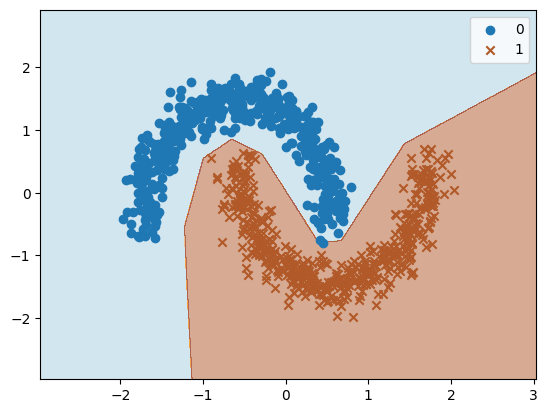

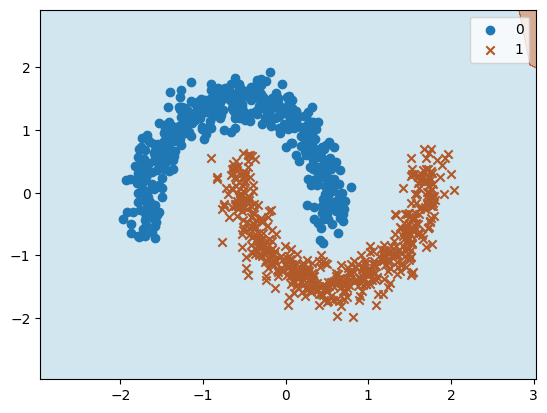

In [18]:
m = MLP(2, [8], 1)
weights, angle = dataset[1000]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights)
    list_to_model(m, out.tolist())
    plot_decision_boundary(m, X, y) 

## Projection

In [36]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(8),
            torch.nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(8),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 33)
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder2(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
config = {
    "model":{
        "name": "Autoencoder small with batchnorm",
        "layers": [33, 16, 8, 2]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]


encoder = Encoder2()
decoder = Decoder2()
model = Autoencoder2(encoder, decoder)
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# wandb_config = cfg.load_env()
# wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder")

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

# wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
# wandb.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss: 4.524479866027832
Epoch 2: Loss: 4.303749084472656
Epoch 3: Loss: 4.535054683685303
Epoch 4: Loss: 4.24053430557251
Epoch 5: Loss: 4.410211086273193
Epoch 6: Loss: 4.31292724609375
Epoch 7: Loss: 4.343537330627441
Epoch 8: Loss: 4.297784328460693
Epoch 9: Loss: 4.262441635131836
Epoch 10: Loss: 4.246500015258789
Epoch 11: Loss: 4.218719482421875
Epoch 12: Loss: 4.241344928741455
Epoch 13: Loss: 4.223020553588867
Epoch 14: Loss: 4.287302017211914
Epoch 15: Loss: 4.226526737213135
Epoch 16: Loss: 4.21867561340332
Epoch 17: Loss: 4.216132640838623
Epoch 18: Loss: 4.156768321990967
Epoch 19: Loss: 4.153915882110596
Epoch 20: Loss: 4.126526832580566
Epoch 21: Loss: 4.195276737213135
Epoch 22: Loss: 4.1307759284973145
Epoch 23: Loss: 4.119270324707031
Epoch 24: Loss: 4.2866082191467285
Epoch 25: Loss: 4.055174827575684
Epoch 26: Loss: 4.278680324554443
Epoch 27: Loss: 4.138584613800049
Epoch 28: Loss: 4.004045486450195
Epoch 29: Loss: 4.11122465133667
Epoch 30: Loss: 4.1671786

  0%|          | 0/80000 [00:00<?, ?it/s]

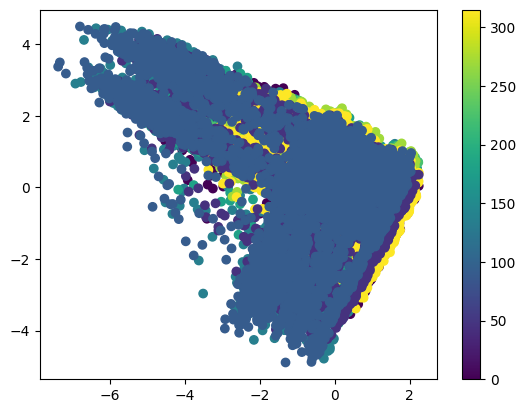

In [39]:
latent = []
angles = []

model.eval()
for i in tqdm(range(len(dataset))):
    X, y = dataset[i]
    X = X.unsqueeze(0).to(device)
    pred = model.encoder(X)
    latent.append(pred.cpu().detach().numpy())
    angles.append(y.cpu().detach().numpy())

latent = np.array(latent).reshape(-1, 2)
angles = np.array(angles).reshape(-1, 8)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(latent)
plt.scatter(latent[:,0], latent[:,1], c=angles.dot([0, 45, 90, 135, 180, 225, 270, 315]), cmap="viridis")
plt.colorbar()
plt.show()

## Variational Autoencoder to generate weights

In [140]:
def reparameterize(mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std

class Encoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 10),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Decoder, self).__init__()

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 33),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class Variational(torch.nn.Module):
    def __init__(self) -> None:
        super(Variational, self).__init__()
        
        self.encoder = Encoder()
        self.mean = torch.nn.Linear(10, 10)
        self.var = torch.nn.Linear(10, 10)
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        mean = self.mean(latent)
        var = self.var(latent)
        x = reparameterize(mean, var)
        output = self.decoder(x)
        return output, mean, var

In [148]:
variational = Variational()
loss_fn = torch.nn.functional.binary_cross_entropy
optimizer = torch.optim.Adam(variational.parameters(), lr=0.001)
device = torch.device("cuda:0")

In [149]:
dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataset.normalize()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [150]:
epochs = 100

for i in tqdm(range(epochs)):
    for X, y in dataloader:
        output, mean, var = variational(X)

        loss = loss_fn(output, X, reduction='sum')
        kl_div = -0.5*torch.sum(1 + var - mean.pow(2) - var.exp())
        loss += kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 731.4895629882812
Epoch: 2, Loss: 731.8525390625
Epoch: 3, Loss: 731.3154907226562
Epoch: 4, Loss: 731.244140625
Epoch: 5, Loss: 731.9208374023438
Epoch: 6, Loss: 731.6766357421875
Epoch: 7, Loss: 731.5616455078125
Epoch: 8, Loss: 731.4656982421875
Epoch: 9, Loss: 731.4236450195312
Epoch: 10, Loss: 731.5119018554688
Epoch: 11, Loss: 731.5067749023438
Epoch: 12, Loss: 731.8471069335938
Epoch: 13, Loss: 731.8662109375
Epoch: 14, Loss: 731.7462768554688
Epoch: 15, Loss: 731.5425415039062
Epoch: 16, Loss: 731.9605102539062
Epoch: 17, Loss: 731.8154296875
Epoch: 18, Loss: 731.7398681640625
Epoch: 19, Loss: 731.4356689453125
Epoch: 20, Loss: 731.6376953125
Epoch: 21, Loss: 731.694580078125
Epoch: 22, Loss: 731.6629028320312
Epoch: 23, Loss: 731.3163452148438
Epoch: 24, Loss: 731.5230712890625
Epoch: 25, Loss: 731.9188842773438
Epoch: 26, Loss: 731.3572387695312
Epoch: 27, Loss: 731.6742553710938
Epoch: 28, Loss: 731.4759521484375
Epoch: 29, Loss: 731.53125
Epoch: 30, Loss: 73

In [185]:
model = MLP(2, [8], 1)
weights, angle = dataset[1000]
w = dataset.denormalize(weights)
list_to_model(model, w.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(model, X, y)

variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights)
    latent = reparameterize(mean, var)
    output = variational.decoder(latent)
    w = dataset.denormalize(output)
    list_to_model(model, w.tolist())
    plot_decision_boundary(model, X, y) 

AttributeError: 'ModelParamsDataset2' object has no attribute 'denormalize'

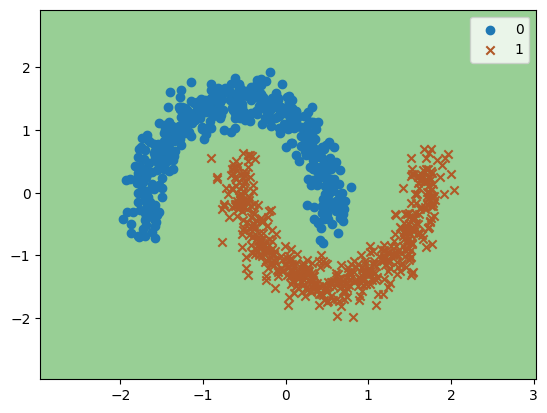

In [176]:
variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights)
    latent = reparameterize(mean, var)
    output = variational.decoder(latent)
    w = dataset.denormalize(output)
    list_to_model(model, w.tolist())
    plot_decision_boundary(model, X, y) 